In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns

# 讀取數據
df = pd.read_csv('HR_capstone_dataset.csv')
df = df[~df.duplicated()]

In [51]:

# 定義類別和數值欄位
categorical_features = ['Department', 'salary', 'promotion_last_5years', 'Work_accident']
numeric_features = [col for col in df.columns if col not in categorical_features + ['left']]

# 數據前處理
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# 組合平衡數據集的處理管道
smt = SMOTE(sampling_strategy='auto')
tl = TomekLinks(sampling_strategy='auto')

# 定義三個模型的參數網格
model_params = {
    'LogisticRegression': {
        'classifier': [LogisticRegression()],
        'classifier__C': [0.1, 1, 10]
    },
    'RandomForestClassifier': {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [10, 50, 100],
        'classifier__max_depth': [None, 10, 20, 30]
    },
    'SVC': {
        'classifier': [SVC(probability=True)],
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf']
    }
}

results = []

# 訓練測試分割
X = df.drop('left', axis=1)
y = df['left']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

predict_result = {}
# 比較三種模型
for model_name, param_grid in model_params.items():
    model_pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('sampler', smt),
        ('tomek', tl),
        ('classifier', param_grid['classifier'][0])
    ])
    search = GridSearchCV(model_pipeline, param_grid, cv=5, error_score='raise')
    search.fit(X_train, y_train)
    y_pred = search.predict(X_test)
    y_pred_prob = search.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_prob)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} best parameters: {search.best_params_}")
    print(classification_report(y_test, y_pred))
    predict_result[model_name] = (confusion_matrix(y_test, y_pred), auc)

LogisticRegression best parameters: {'classifier': LogisticRegression(), 'classifier__C': 0.1}
              precision    recall  f1-score   support

           0       0.96      0.77      0.86      1998
           1       0.42      0.84      0.56       401

    accuracy                           0.78      2399
   macro avg       0.69      0.80      0.71      2399
weighted avg       0.87      0.78      0.81      2399

RandomForestClassifier best parameters: {'classifier': RandomForestClassifier(), 'classifier__max_depth': None, 'classifier__n_estimators': 100}
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1998
           1       0.97      0.89      0.93       401

    accuracy                           0.98      2399
   macro avg       0.97      0.94      0.96      2399
weighted avg       0.98      0.98      0.98      2399

SVC best parameters: {'classifier': SVC(probability=True), 'classifier__C': 10, 'classifier__kernel': 'rbf

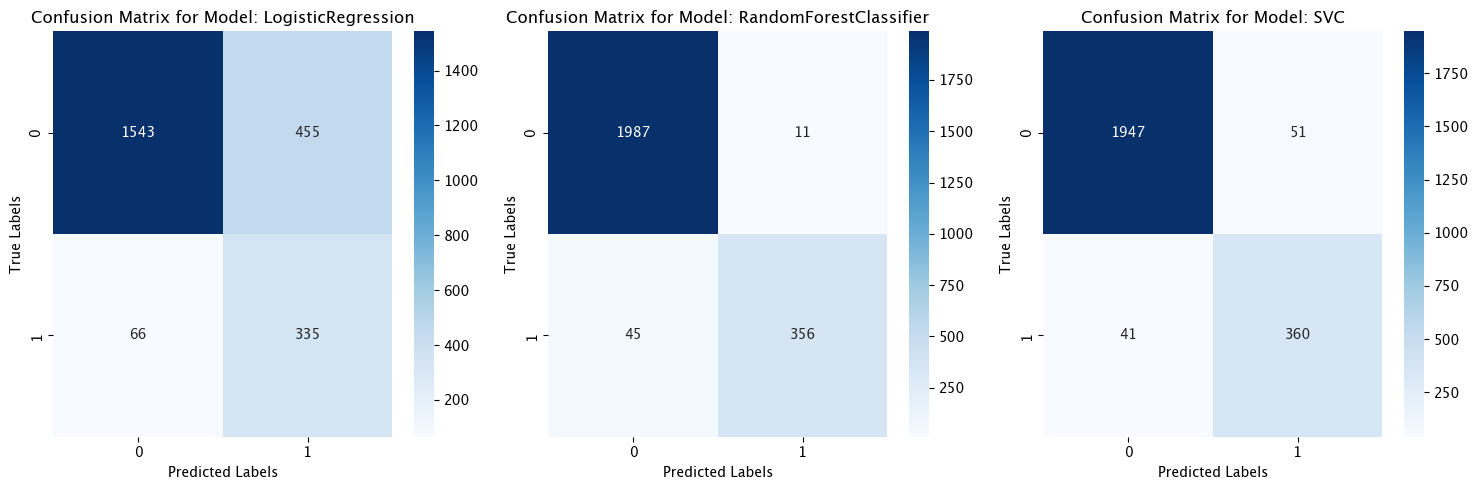

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))  # 設定一行三列的子圖

for index, model_name in enumerate(predict_result):
    sns.heatmap(predict_result[model_name][0], annot=True, fmt='d', cmap='Blues', ax=ax[index])
    ax[index].set_title(f'Confusion Matrix for Model: {model_name}')
    ax[index].set_xlabel('Predicted Labels')
    ax[index].set_ylabel('True Labels')

plt.tight_layout()
plt.show()


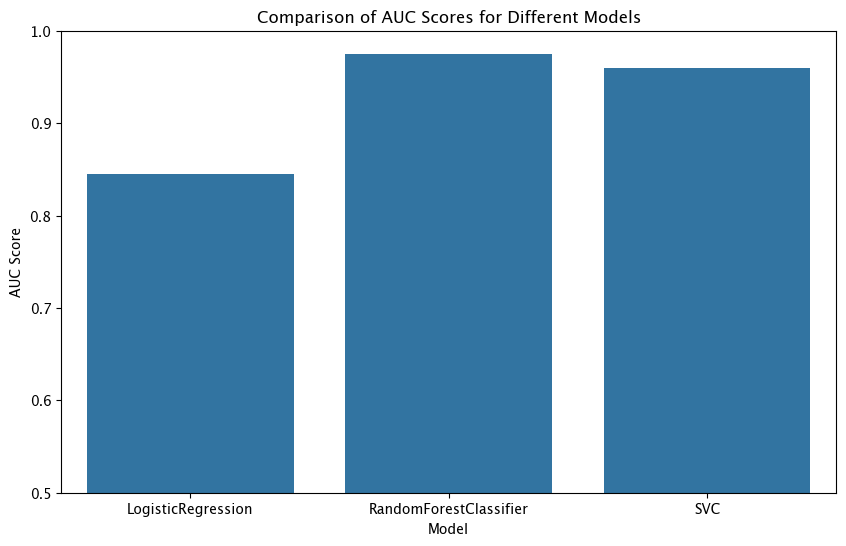

In [53]:
# 創建一個 DataFrame
data = {}
models = []
auc = []
for model_name, value in predict_result.items():
    models.append(model_name)
    auc.append(value[1])
data = {
    'Model': models,
    'AUC': auc
}
df_auc = pd.DataFrame(data)

# 繪製 barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='AUC', data=df_auc)
plt.title('Comparison of AUC Scores for Different Models')
plt.xlabel('Model')
plt.ylabel('AUC Score')
plt.ylim(0.5, 1.0)  # 設定 y 軸範圍以強調差異
plt.show()

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1998
           1       0.97      0.89      0.93       401

    accuracy                           0.98      2399
   macro avg       0.97      0.94      0.96      2399
weighted avg       0.98      0.98      0.98      2399



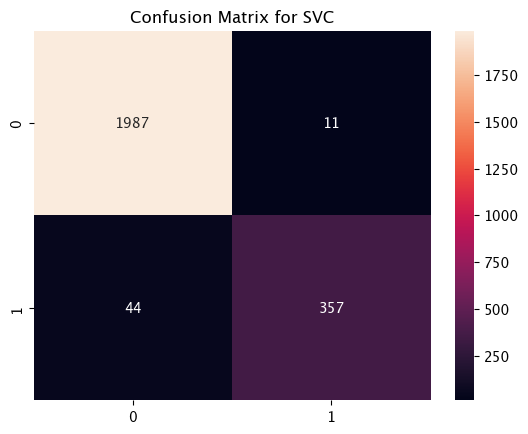

In [46]:
model = RandomForestClassifier(max_depth=30, n_estimators=50)
model_pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('sampler', smt),
        ('tomek', tl),
        ("classifier", model)
    ])
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()